In [96]:
#Usual importing to start
import xgboost as xgb
from astropy.io import fits
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from astropy.table import Table, hstack, vstack
from collections import Counter
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.stats import norm
import matplotlib

ModuleNotFoundError: No module named 'pyplot'

In [2]:
#Open the data
data1 = Table.read('big_table_1.fits',format = 'fits')
data2 = Table.read('big_table_2.fits',format = 'fits')
data3 = Table.read('big_table_3.fits',format = 'fits')
data4 = Table.read('big_table_4.fits',format = 'fits')
data5 = Table.read('big_table_5.fits',format = 'fits')
data6 = Table.read('big_table_6.fits',format = 'fits')
data7 = Table.read('big_table_7.fits',format = 'fits')
data8 = Table.read('big_table_8.fits',format = 'fits')

In [3]:
#Combine the data
data = np.concatenate((data1,data2,data3,data4,data5,data6,data7,data8))

#Look at the distribution of object types
Counter(data['objtype'])

Counter({b'Star': 5960751,
         b'': 1678433,
         b'Galaxy': 150581,
         b'other': 2172,
         b'QSOlowZ': 16274,
         b'QSOhighZ': 1903})

In [4]:
#Create a label array
label = data['objtype']

#Label sources with proper motion as stars
label[(label == b'') & (abs(data['pmra']/data['pmra_error']) > 3)] = b'Star'
label[(label == b'') & (abs(data['pmdec']/data['pmdec_error']) > 3)] = b'Star'

In [5]:
#Label sources with parallax as stars
label[(data['objtype'] == b'') & (data['parallax_over_error'] > 3)] = b'Star'

#Look at the distribution of object types
Counter(data['objtype'])

Counter({b'Star': 5986025,
         b'': 1653159,
         b'Galaxy': 150581,
         b'other': 2172,
         b'QSOlowZ': 16274,
         b'QSOhighZ': 1903})

In [6]:
#Throw away the unlabeled sources
data = data[label != b'']
label = label[label != b'']

#Make the colors for the whole sample
g = data['phot_g_mean_mag']
b_minus_g = data['phot_bp_mean_mag']-g
g_minus_r = g-data['phot_rp_mean_mag']
r_minus_i = data['rPSFMag']-data['iPSFMag']
i_minus_z = data['iPSFMag']-data['zPSFMag']
z_minus_y = data['zPSFMag']-data['yPSFMag']
y_minus_w1 = data['yPSFMag']-data['w1mpro']
w1_minus_w2 = data['w1mpro']-data['w2mpro']
w2_minus_w3 = data['w2mpro']-data['w3mpro']
w3_minus_w4 = data['w3mpro']-data['w4mpro']
z = data['z_spec']

In [7]:
#Put the features together
features_all = np.column_stack((g,b_minus_g,g_minus_r,r_minus_i,i_minus_z,z_minus_y,y_minus_w1,w1_minus_w2,w2_minus_w3,w3_minus_w4,z))

In [112]:
#Separate test and training data
features_train, features_test, Y_train, Y_test = train_test_split(features_all, label, test_size=0.2)

#Look at the distribution of object types in the test set
Counter(Y_test)

Counter({b'Star': 1197113,
         b'QSOlowZ': 3260,
         b'Galaxy': 30252,
         b'other': 422,
         b'QSOhighZ': 344})

In [113]:
#Make a dataset from the QSOs alone to use for regression
Y_for_z = features_train[(Y_train == b'QSOhighZ') | (Y_train == b'QSOlowZ'),10]
X_for_z = features_train[(Y_train == b'QSOhighZ') | (Y_train == b'QSOlowZ'),:10]
Y_for_z_test = features_test[(Y_test == b'QSOhighZ') | (Y_test == b'QSOlowZ'),10]
X_for_z_test = features_test[(Y_test == b'QSOhighZ') | (Y_test == b'QSOlowZ'),:10]

[0]	validation_0-rmse:0.87617	validation_1-rmse:0.84779
[1]	validation_0-rmse:0.64843	validation_1-rmse:0.63023
[2]	validation_0-rmse:0.49415	validation_1-rmse:0.48606
[3]	validation_0-rmse:0.39129	validation_1-rmse:0.39405
[4]	validation_0-rmse:0.32536	validation_1-rmse:0.33602
[5]	validation_0-rmse:0.28299	validation_1-rmse:0.30224
[6]	validation_0-rmse:0.25571	validation_1-rmse:0.28132
[7]	validation_0-rmse:0.24050	validation_1-rmse:0.27015
[8]	validation_0-rmse:0.22972	validation_1-rmse:0.26347
[9]	validation_0-rmse:0.22122	validation_1-rmse:0.25892
R^2: [0.92207831 0.92822589 0.91357952 0.92814856 0.90526071]


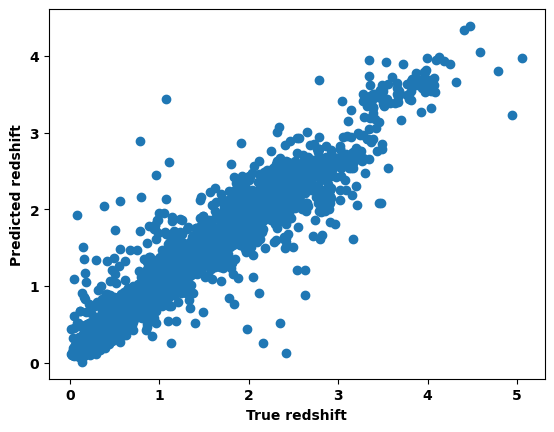

In [114]:
#Run the model
evalset = [(X_for_z,Y_for_z),(X_for_z_test,Y_for_z_test)]
model = xgb.XGBRegressor(n_estimators = 10)
model.fit(X_for_z,Y_for_z,eval_set = evalset)

#Plot predicted vs true
preds = model.predict(X_for_z_test)
plt.xlabel('True redshift')
plt.ylabel('Predicted redshift')
plt.scatter(Y_for_z_test,preds)

#Cross validate to find R^2
scores = cross_val_score(model, X_for_z, Y_for_z, scoring='r2', n_jobs=-1)
print('R^2:',scores)

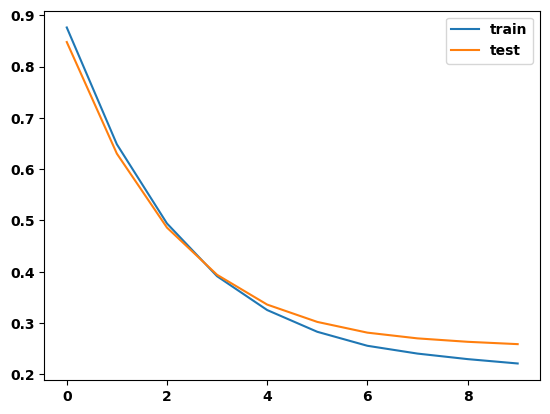

In [115]:
# retrieve performance metrics
results = model.evals_result()

# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()

In [116]:
#Find the variance to fit for each training point
preds_train = model.predict(X_for_z)
variance_train = np.square(Y_for_z-preds_train)

#Fit a model to the variance
variance_model = xgb.XGBRegressor(n_estimators = 10)
variance_model.fit(X_for_z,variance_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

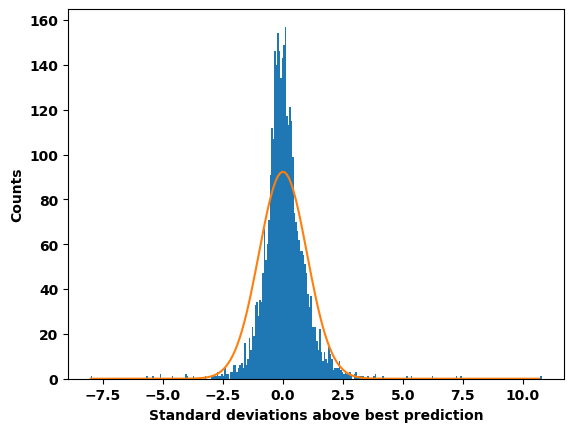

In [117]:
#Look at how the actual zs in the test set compare to their predicted value and variance
predicted_variance = variance_model.predict(X_for_z_test)
deviation = (Y_for_z_test-preds)/np.sqrt(abs(predicted_variance))
bin_no = 300
plt.hist(deviation,bins = bin_no)
plt.xlabel('Standard deviations above best prediction')
plt.ylabel('Counts')
x_axis = np.arange(min(deviation),max(deviation),(max(deviation)-min(deviation))/200)
plt.plot(x_axis, 3693*norm.pdf(x_axis, 0, 1)*(max(deviation)-min(deviation))/bin_no)

In [118]:
#Assign an ostensible z and variance for each source, assuming it is a QSO
X_train = features_train[:,:10]
X_test = features_test[:,:10]
z_if_qso_train = model.predict(X_train)
z_if_qso_test = model.predict(X_test)
variance_if_qso_train = variance_model.predict(X_train)
variance_if_qso_test = variance_model.predict(X_test)

In [119]:
#Draw out z and variance from what we know to be high z QSOs and stars
z_qso = z_if_qso_train[Y_train == b'QSOhighZ']
variance_qso = variance_if_qso_train[Y_train == b'QSOhighZ']
z_star = z_if_qso_train[Y_train == b'Star']
variance_star = variance_if_qso_train[Y_train == b'Star']

Text(0, 0.5, 'Variance of estimated redshift')

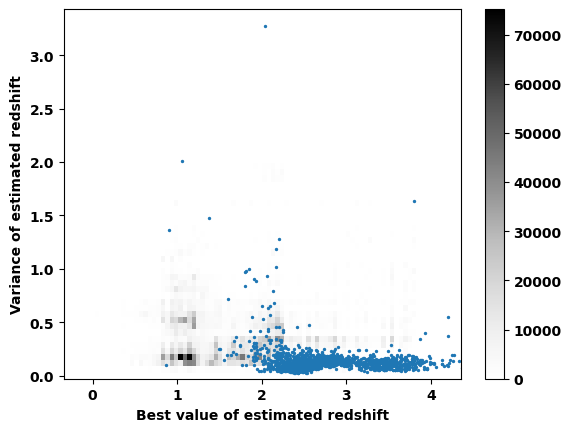

In [120]:
# Plot the star and high z QSO data
plt.hist2d(z_star,variance_star,bins = [90,60],cmap = 'Greys')
plt.colorbar()
plt.scatter(z_qso,variance_qso,s = 2)
plt.xlabel('Best value of estimated redshift')
plt.ylabel('Variance of estimated redshift')

Text(0, 0.5, 'Counts')

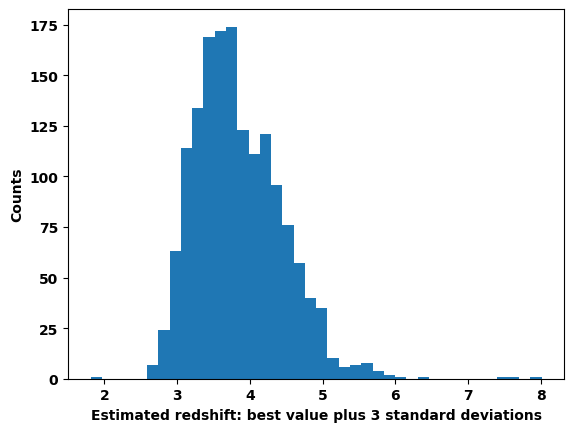

In [121]:
#Plot the largest plausible z for QSOs
plt.hist(z_qso+3*np.sqrt(abs(variance_qso)),bins = 40)
plt.xlabel('Estimated redshift: best value plus 3 standard deviations')
plt.ylabel('Counts')

(array([2.00000e+00, 1.00000e+00, 7.00000e+00, 2.00000e+00, 1.70000e+01,
        4.10000e+01, 5.40000e+01, 1.87000e+02, 1.20000e+02, 1.95000e+02,
        1.75000e+02, 1.01000e+02, 9.80000e+01, 1.66000e+02, 1.71000e+02,
        1.40000e+02, 1.40000e+02, 1.13000e+02, 1.85000e+02, 1.26000e+02,
        1.67000e+02, 2.44000e+02, 2.35000e+02, 2.15000e+02, 2.48000e+02,
        3.09000e+02, 4.65000e+02, 3.65000e+02, 7.14000e+02, 1.08500e+03,
        1.30100e+03, 4.19600e+03, 3.06800e+03, 4.89200e+03, 3.46700e+03,
        4.80200e+03, 5.33800e+03, 8.52500e+03, 9.41600e+03, 1.25680e+04,
        1.44260e+04, 1.96500e+04, 2.43660e+04, 2.96830e+04, 3.70110e+04,
        5.17850e+04, 5.43010e+04, 6.61150e+04, 6.82510e+04, 1.05348e+05,
        7.61530e+04, 7.23300e+04, 7.82660e+04, 6.31660e+04, 6.12490e+04,
        5.21580e+04, 5.51250e+04, 4.74630e+04, 4.55560e+04, 4.76220e+04,
        4.87970e+04, 5.57950e+04, 5.46010e+04, 6.31610e+04, 7.97290e+04,
        9.57110e+04, 9.80850e+04, 7.84040e+04, 9.24

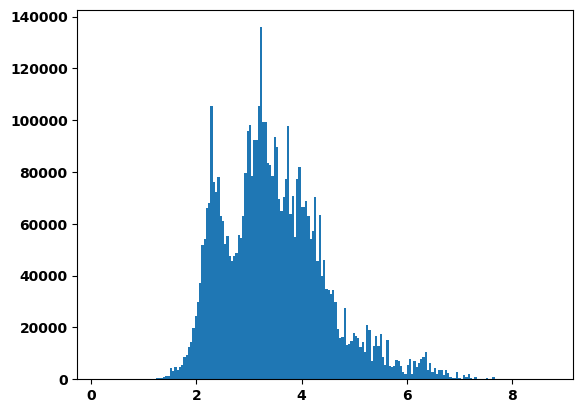

In [122]:
#Plot the largest plausible z for stars
plt.hist(z_star+3*np.sqrt(abs(variance_star)),bins = 200)

In [123]:
#Old method: discard those sources with ostensible z below 2.5
X_train_old = X_train[z_if_qso_train > 2.5,:]
Y_train_old = Y_train[z_if_qso_train > 2.5]
z_if_qso_train_old = z_if_qso_train[z_if_qso_train > 2.5]
X_test_old = X_test[z_if_qso_test > 2.5,:]
Y_test_old = Y_test[z_if_qso_test > 2.5]
z_if_qso_test_old = z_if_qso_test[z_if_qso_test > 2.5]

#Look at the distribution of object types
print(Counter(Y_train_old))
print(Counter(Y_test_old))

#Add ostensible z to the input data
X_train_augmented_old = np.concatenate((X_train_old,np.vstack(z_if_qso_train_old)),axis = 1)
X_test_augmented_old = np.concatenate((X_test_old,np.vstack(z_if_qso_test_old)),axis = 1)
                                       
#Reduce to numerical labels
Y_train_number_old = (Y_train_old == b'QSOhighZ')+(Y_train_old == b'QSOlowZ')+2*(Y_train_old == b'Galaxy')+2*(Y_train_old == b'other')
Y_test_number_old = (Y_test_old == b'QSOhighZ')+(Y_test_old == b'QSOlowZ')+2*(Y_test_old == b'Galaxy')+2*(Y_test_old == b'other')

Counter({b'Star': 699223, b'QSOhighZ': 1045, b'Galaxy': 217, b'QSOlowZ': 151, b'other': 7})
Counter({b'Star': 174735, b'QSOhighZ': 214, b'Galaxy': 66, b'QSOlowZ': 40, b'other': 2})


In [124]:
#Fit the model
bst_old = xgb.XGBClassifier(n_estimators = 20)
bst_old.fit(X_train_augmented_old,Y_train_number_old)

#Make predictions on the test set
predicted_classes_old = bst_old.predict(X_test_augmented_old)

#Show the confusion matrix
print(confusion_matrix(Y_test_number_old,predicted_classes_old))

#See how the high z QSOs have been labeled
highz_destinies_old = predicted_classes_old[Y_test_old == b'QSOhighZ']
Counter(highz_destinies_old)

[[174718      7     10]
 [     6    248      0]
 [    63      1      4]]


Counter({1: 208, 0: 6})

In [125]:
#Discard those sources with ostensible z below 2.5
X_train = X_train[z_if_qso_train+3*np.sqrt(abs(variance_if_qso_train)) > 2.5,:]
Y_train = Y_train[z_if_qso_train+3*np.sqrt(abs(variance_if_qso_train)) > 2.5]
z_if_qso_train = z_if_qso_train[z_if_qso_train+3*np.sqrt(abs(variance_if_qso_train)) > 2.5]
X_test = X_test[z_if_qso_test+3*np.sqrt(abs(variance_if_qso_test)) > 2.5,:]
Y_test = Y_test[z_if_qso_test+3*np.sqrt(abs(variance_if_qso_test)) > 2.5]
z_if_qso_test = z_if_qso_test[z_if_qso_test+3*np.sqrt(abs(variance_if_qso_test)) > 2.5]

In [126]:
#Add ostensible z to the input data
X_train_augmented = np.concatenate((X_train,np.vstack(z_if_qso_train)),axis = 1)
X_test_augmented = np.concatenate((X_test,np.vstack(z_if_qso_test)),axis = 1)

#Look at the distribution of object types
print(Counter(Y_train))
print(Counter(Y_test))

Counter({b'Star': 3937859, b'Galaxy': 10613, b'QSOlowZ': 2681, b'QSOhighZ': 1558, b'other': 34})
Counter({b'Star': 984298, b'Galaxy': 2666, b'QSOlowZ': 660, b'QSOhighZ': 341, b'other': 5})


In [127]:
#Reduce to numerical labels
Y_train_number = (Y_train == b'QSOhighZ')+(Y_train == b'QSOlowZ')+2*(Y_train == b'Galaxy')+2*(Y_train == b'other')
Y_test_number = (Y_test == b'QSOhighZ')+(Y_test == b'QSOlowZ')+2*(Y_test == b'Galaxy')+2*(Y_test == b'other')

# define the datasets to evaluate each iteration
evalset = [(X_train_augmented, Y_train_number), (X_test_augmented,Y_test_number)]

#Fit the model
bst = xgb.XGBClassifier(n_estimators = 20)
print(X_train_augmented.shape)
print(Y_train_number.shape)
bst.fit(X_train_augmented,Y_train_number,eval_set = evalset)

(3952745, 11)
(3952745,)
[0]	validation_0-mlogloss:0.70507	validation_1-mlogloss:0.70508
[1]	validation_0-mlogloss:0.48406	validation_1-mlogloss:0.48409
[2]	validation_0-mlogloss:0.34295	validation_1-mlogloss:0.34300
[3]	validation_0-mlogloss:0.24779	validation_1-mlogloss:0.24785
[4]	validation_0-mlogloss:0.18164	validation_1-mlogloss:0.18173
[5]	validation_0-mlogloss:0.13479	validation_1-mlogloss:0.13490
[6]	validation_0-mlogloss:0.10121	validation_1-mlogloss:0.10134
[7]	validation_0-mlogloss:0.07695	validation_1-mlogloss:0.07711
[8]	validation_0-mlogloss:0.05931	validation_1-mlogloss:0.05951
[9]	validation_0-mlogloss:0.04643	validation_1-mlogloss:0.04665
[10]	validation_0-mlogloss:0.03701	validation_1-mlogloss:0.03726
[11]	validation_0-mlogloss:0.03011	validation_1-mlogloss:0.03039
[12]	validation_0-mlogloss:0.02501	validation_1-mlogloss:0.02532
[13]	validation_0-mlogloss:0.02126	validation_1-mlogloss:0.02159
[14]	validation_0-mlogloss:0.01849	validation_1-mlogloss:0.01885
[15]	valid

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=20, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [128]:
#Make predictions on the test set
predicted_classes = bst.predict(X_test_augmented)

In [129]:
#Show the confusion matrix
confusion_matrix(Y_test_number,predicted_classes)

array([[984248,     19,     31],
       [    91,    906,      4],
       [  2270,      5,    396]], dtype=int64)

In [130]:
#See how the high z QSOs have been labeled
highz_destinies = predicted_classes[Y_test == b'QSOhighZ']
Counter(highz_destinies)

Counter({1: 310, 0: 30, 2: 1})

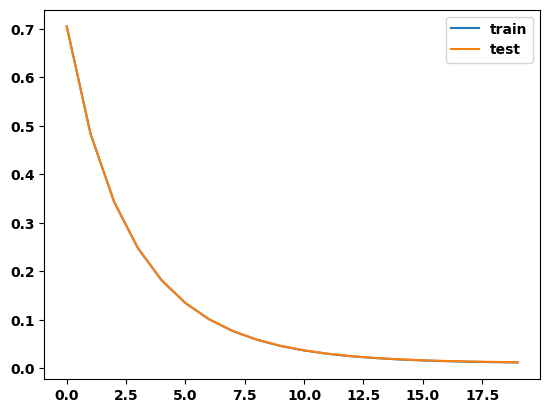

In [131]:
# retrieve performance metrics
results = bst.evals_result()

# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()